In [ ]:
from main import get_last_data_path
import pickle
from consts import GEMMA_2

data_dir = "data"

data_path = get_last_data_path(data_dir)
with open(data_path, "rb") as f:
    data = pickle.load(f)

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
gemma_2_data = data[GEMMA_2]
position = -1

print(gemma_2_data.keys())

dict_keys(['1161', '1200', '137', '3949', '4086', '4287', '5548', '6832', '695', '709', '7988', '8015'])


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

def train_and_save_plot(steering_vector_name, all_vectors, mlp_vs_attn):
    tsne = TSNE(n_components=2, perplexity=3, random_state=42, metric='cosine')
    X_tsne = tsne.fit_transform(all_vectors)

    reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    X_umap = reducer.fit_transform(all_vectors)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    class_names = ['vector', 'mlp', 'attn', 'resid']

    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
    ax1.set_title('t-SNE Visualization', fontsize=16)
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.grid(True, linestyle='--', alpha=0.6)
    handles, _ = scatter1.legend_elements()
    legend1 = ax1.legend(handles, class_names, title='Components')
    ax1.add_artist(legend1)

    scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
    ax2.set_title('UMAP Visualization', fontsize=16)
    ax2.set_xlabel('UMAP Component 1')
    ax2.set_ylabel('UMAP Component 2')
    ax2.grid(True, linestyle='--', alpha=0.6)
    handles, _ = scatter2.legend_elements()
    legend2 = ax2.legend(handles, class_names, title='Components')
    ax2.add_artist(legend2)

    plt.suptitle('t-SNE and UMAP - labeled by component type', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'tsne_graphs/{steering_vector_name}_tsne_umap.png')


In [20]:
import numpy as np
import re

name_mapping = {'vector': 0, 'mlp': 1, 'attn': 2}#, 'resid': 3}
all_vectors = []
mlp_vs_attn = []
for steering_vector, per_vector_data in gemma_2_data.items():
    current_vectors = []
    current_mlp_vs_attn = []

    vec = per_vector_data['meta']['direction']
    current_vectors.append(vec.float())
    current_mlp_vs_attn.append(name_mapping['vector'])
    data_at_position = per_vector_data['all']
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train
    for component_name in negative_agg_train.keys():
        # re_pattern = 'blocks\.(\d+)\.*'
        # layer_num = re.search(re_pattern, component_name).group(1)
        # layer_num = int(layer_num)
        # if layer_num < 15:
        #     continue
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]
        if 'ln2' in component_name:
            current_mlp_vs_attn.append(name_mapping['mlp'])
            current_vectors.append(diff_means.float())
        elif 'ln1' in component_name:
            current_mlp_vs_attn.append(name_mapping['attn'])
            current_vectors.append(diff_means.float())

    current_vectors = np.array(current_vectors)
    all_vectors.append(current_vectors)
    mlp_vs_attn.append(current_mlp_vs_attn)

    # train_and_save_plot(steering_vector, current_vectors, current_mlp_vs_attn)
all_vectors = np.array(all_vectors)
mlp_vs_attn = np.array(mlp_vs_attn)


In [21]:
mlp_vs_attn = mlp_vs_attn[0]

In [22]:
all_vectors = all_vectors.transpose(1,0,2)
all_vectors = all_vectors.reshape(all_vectors.shape[0], -1)


In [25]:
print("\nRunning t-SNE...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42)#, metric='cosine')
X_tsne = tsne.fit_transform(all_vectors)


print("\nRunning UMAP...")
reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)#, metric='cosine')
X_umap = reducer.fit_transform(all_vectors)



Running t-SNE...

Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Generating plots...


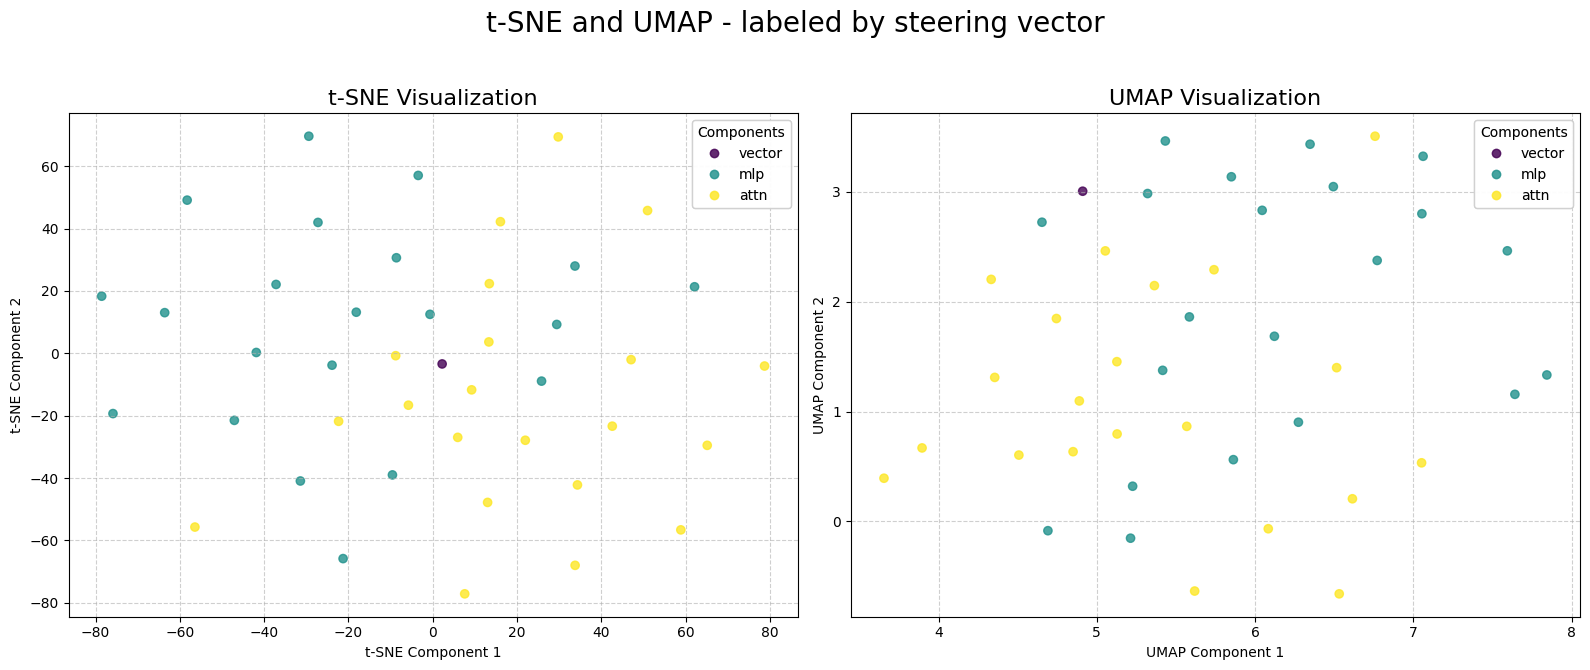

Done.


In [26]:
print("\nGenerating plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


class_names = ['vector', 'mlp', 'attn', 'resid']

scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
ax1.set_title('t-SNE Visualization', fontsize=16)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.grid(True, linestyle='--', alpha=0.6)
handles, _ = scatter1.legend_elements()
legend1 = ax1.legend(handles, class_names, title='Components')
ax1.add_artist(legend1)

scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
ax2.set_title('UMAP Visualization', fontsize=16)
ax2.set_xlabel('UMAP Component 1')
ax2.set_ylabel('UMAP Component 2')
ax2.grid(True, linestyle='--', alpha=0.6)
handles, _ = scatter2.legend_elements()
legend2 = ax2.legend(handles, class_names, title='Components')
ax2.add_artist(legend2)

plt.suptitle('t-SNE and UMAP - labeled by steering vector', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Done.")